In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pingouin as pg
import re
import seaborn as sns

from glob import glob
from sklearn.metrics import cohen_kappa_score

In [2]:
qc_files = glob("../expert-ratings/expertqc*.csv")

expert_qc = dd.read_csv(qc_files, usecols=["subject", "rating"], include_path_column=True).compute()
expert_qc["rater"] = expert_qc["path"].apply(
    lambda s: op.basename(s).replace("expertqc-", "").replace(".csv", "")
).astype(str)
expert_qc.drop("path", axis="columns", inplace=True)
expert_qc.reset_index(drop=True, inplace=True)

/Users/richford/miniconda3/envs/hbn-pod2-qc/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
print(expert_qc.shape)

(1200, 3)


In [4]:
expert_qc.head()

,subject,rating,rater
0,sub-NDARTF781TM8_ses-HBNsiteCBIC,1,wrathfulMuesli7
1,sub-NDARVC711ZK0_ses-HBNsiteCBIC,-1,wrathfulMuesli7
2,sub-NDARDX857DLB_ses-HBNsiteRU,1,wrathfulMuesli7
3,sub-NDARJH492TVW_ses-HBNsiteCBIC,1,wrathfulMuesli7
4,sub-NDARTB203DU7_ses-HBNsiteCBIC,-1,wrathfulMuesli7


In [ ]:
osf_expert_qc = 

In [5]:
expert_qc.groupby("subject").agg(["mean", "median", "std", "min", "max", "count"])

rating                               
                                      mean median       std min max count
subject                                                                  
sub-NDARAC857HDB_ses-HBNsiteCBIC -2.000000   -2.0  0.000000  -2  -2     6
sub-NDARAH304ED7_ses-HBNsiteRU    0.833333    1.0  1.169045  -1   2     6
sub-NDARAJ689BVN_ses-HBNsiteRU    1.166667    1.0  0.752773   0   2     6
sub-NDARAP785CTE_ses-HBNsiteRU   -2.000000   -2.0  0.000000  -2  -2     6
sub-NDARAU530GLJ_ses-HBNsiteCBIC  1.500000    1.5  0.547723   1   2     6
...                                    ...    ...       ...  ..  ..   ...
sub-NDARZE963MEU_ses-HBNsiteCBIC  1.666667    2.0  0.516398   1   2     6
sub-NDARZH672BAM_ses-HBNsiteRU    1.333333    2.0  1.211060  -1   2     6
sub-NDARZR968TLL_ses-HBNsiteCUNY -1.333333   -1.0  0.516398  -2  -1     6
sub-NDARZV421TCZ_ses-HBNsiteCBIC -1.166667   -1.0  0.752773  -2   0     6
sub-NDARZV749GAP_ses-HBNsiteCBIC  1.333333    1.0  0.516398   1   2     6

[200 rows x 6 columns]

In [6]:
mean_expert_rating = expert_qc.groupby("subject").agg("mean")
mean_expert_rating["subject"] = mean_expert_rating.index

r = re.compile("ses-HBNsite([a-zA-Z0-9]*)")
mean_expert_rating["site"] = mean_expert_rating["subject"].apply(lambda s: r.search(s).group(1))

r = re.compile("sub-([a-zA-Z0-9]*)_")
mean_expert_rating["subject"] = mean_expert_rating["subject"].apply(lambda s: r.search(s).group(1))

mean_expert_rating.set_index("subject", drop=True, inplace=True)
mean_expert_rating

,rating,site
subject,,
NDARAC857HDB,-2.000000,CBIC
NDARAH304ED7,0.833333,RU
NDARAJ689BVN,1.166667,RU
NDARAP785CTE,-2.000000,RU
NDARAU530GLJ,1.500000,CBIC
...,...,...
NDARZE963MEU,1.666667,CBIC
NDARZH672BAM,1.333333,RU
NDARZR968TLL,-1.333333,CUNY


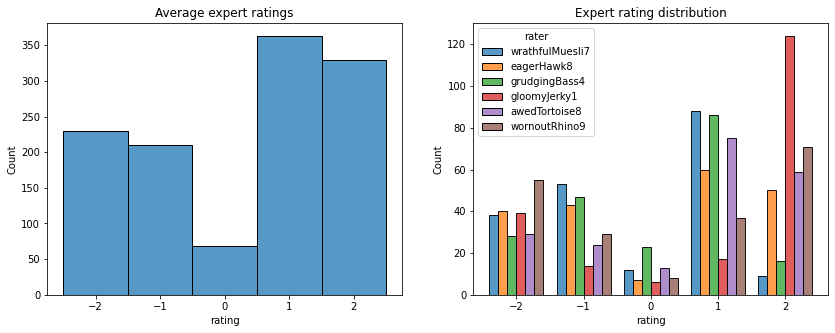

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

_ = sns.histplot(
    data=expert_qc,
    x="rating",
    bins=np.linspace(-2.5, 2.5, 6),
    ax=ax[0]
)

_ = sns.histplot(
    data=expert_qc,
    x="rating",
    bins=np.linspace(-2.5, 2.5, 6),
    hue="rater",
    multiple="dodge",
    shrink=0.8,
    ax=ax[1]
)

_ = ax[0].set_title("Average expert ratings")
_ = ax[1].set_title("Expert rating distribution")

# Inter-rater reliability (IRR)
## Compute pairwise Cohen's alpha for each pair of raters

In [8]:
ratings = expert_qc.pivot(index="subject", columns="rater", values="rating")

cohen_kappas = {}
for rater in ratings.columns:
    cohen_kappas[rater] = [
        cohen_kappa_score(
            ratings[rater].to_numpy(),
            ratings[other_rater].to_numpy(),
            labels=[-2, -1, 0, 1, 2],
            weights="quadratic",
        ) for other_rater in ratings.columns
    ]

df_kappa = pd.DataFrame(cohen_kappas, index=ratings.columns)
for rater in ratings.columns:
    df_kappa.loc[rater, rater] = np.nan

df_kappa["mean"] = df_kappa.mean(axis="columns")
print("pairwise kappa values:")
display(df_kappa)
print(f"\nMean kappa across all raters = {df_kappa.mean().mean()}")

pairwise kappa values:


,awedTortoise8,eagerHawk8,gloomyJerky1,grudgingBass4,wornoutRhino9,wrathfulMuesli7,mean
rater,,,,,,,
awedTortoise8,NaN,0.752557,0.838636,0.674447,0.609871,0.642471,0.703597
eagerHawk8,0.752557,NaN,0.731975,0.574662,0.645453,0.700191,0.680968
gloomyJerky1,0.838636,0.731975,NaN,0.571451,0.657881,0.594976,0.678984
grudgingBass4,0.674447,0.574662,0.571451,NaN,0.522337,0.597786,0.588137
wornoutRhino9,0.609871,0.645453,0.657881,0.522337,NaN,0.600308,0.607170
wrathfulMuesli7,0.642471,0.700191,0.594976,0.597786,0.600308,NaN,0.627147



Mean kappa across all raters = 0.6476669329625543


## Compute intra-class correlation (ICC)

We use the `pingouin` library to compute intra-class correlation and limit our output to the
"**ICC3**" case in which a fixed set of $k$ raters rate each target because our expert QC
was completed using a fully-crossed design. There is no generalization to a larger population of raters.

Furthermore, this reliability can then be estimated using different units of analysis to which
the ICC results will apply, a single rating (i.e. **ICC3**) or for the average of $k$ ratings
(i.e. **ICC3k**).
In this study, since all subjects are coded by multiple raters and the average of their ratings is
used for hypothesis testing, **ICC3k** is appropriate.
However, in studies where a subset of subjects is coded by multiple raters and the reliability of
their ratings is meant to generalize to other subjects rated by only one coder,
a single-measures ICC must be used (i.e. **ICC3**). This does not apply here but we leave the
result for reference.

See [doi:10.20982/tqmp.08.1.p023](doi:10.20982/tqmp.08.1.p023) for further information.

In [9]:
icc = pg.intraclass_corr(
    data=expert_qc,
    targets="subject",
    raters="rater",
    ratings="rating"
).round(3).set_index("Type").filter(like="ICC3", axis="index")
icc

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC3,Single fixed raters,0.688,14.204,199,995,0.0,"[0.64, 0.74]"
ICC3k,Average fixed raters,0.930,14.204,199,995,0.0,"[0.91, 0.94]"


The columns of the above dataframe are:

- `Description`: description of the ICC
- `ICC`: intraclass correlation
- `F`: F statistic
- `df1`: numerator degree of freedom
- `df2`: denominator degree of freedom
- `pval`: p-value
- `CI95%`: 95% confidence intervals around the ICC

Looking at the **ICCk** result, we see that our IRR is excellent. Also note that the **ICC** result is consistent with the average pairwise kappa. Norman and Streiner (2008) show that using a weighted kappa with quadratic weights for ordinal scales is identical to a two-way mixed, single-measures, consistency ICC, and the two may be substituted interchangeably.

In [10]:
fibr_ratings = pd.read_csv("../expert-ratings/fibrqc.csv")

In [11]:
fibr_ratings["subject"] = ratings.index
fibr_ratings["rater"] = "fibr + qsiprep"
fibr_ratings

,subject,rating,rater
0,sub-NDARAC857HDB_ses-HBNsiteCBIC,-2.069781,fibr + qsiprep
1,sub-NDARAH304ED7_ses-HBNsiteRU,1.045181,fibr + qsiprep
2,sub-NDARAJ689BVN_ses-HBNsiteRU,1.382294,fibr + qsiprep
3,sub-NDARAP785CTE_ses-HBNsiteRU,-2.131704,fibr + qsiprep
4,sub-NDARAU530GLJ_ses-HBNsiteCBIC,1.451120,fibr + qsiprep
...,...,...,...
195,sub-NDARZE963MEU_ses-HBNsiteCBIC,1.567487,fibr + qsiprep
196,sub-NDARZH672BAM_ses-HBNsiteRU,1.193575,fibr + qsiprep
197,sub-NDARZR968TLL_ses-HBNsiteCUNY,-0.949967,fibr + qsiprep
198,sub-NDARZV421TCZ_ses-HBNsiteCBIC,-0.912400,fibr + qsiprep


In [12]:
ratings["fibr + qsiprep"] = np.rint(fibr_ratings["rating"].to_numpy())

cohen_kappas = {}
for rater in ratings.columns:
    cohen_kappas[rater] = [
        cohen_kappa_score(
            ratings[rater].to_numpy(),
            ratings[other_rater].to_numpy(),
            labels=[-2, -1, 0, 1, 2],
            weights="quadratic",
        ) for other_rater in ratings.columns
    ]

df_kappa = pd.DataFrame(cohen_kappas, index=ratings.columns)
for rater in ratings.columns:
    df_kappa.loc[rater, rater] = np.nan

df_kappa["mean"] = df_kappa.mean(axis="columns")
print("pairwise kappa values:")
display(df_kappa)
print(f"\nMean kappa across all raters = {df_kappa.mean().mean()}")

pairwise kappa values:


,awedTortoise8,eagerHawk8,gloomyJerky1,grudgingBass4,wornoutRhino9,wrathfulMuesli7,fibr + qsiprep,mean
rater,,,,,,,,
awedTortoise8,NaN,0.752557,0.838636,0.674447,0.609871,0.642471,0.784753,0.717123
eagerHawk8,0.752557,NaN,0.731975,0.574662,0.645453,0.700191,0.752482,0.692887
gloomyJerky1,0.838636,0.731975,NaN,0.571451,0.657881,0.594976,0.762178,0.692850
grudgingBass4,0.674447,0.574662,0.571451,NaN,0.522337,0.597786,0.711453,0.608689
wornoutRhino9,0.609871,0.645453,0.657881,0.522337,NaN,0.600308,0.645495,0.613558
wrathfulMuesli7,0.642471,0.700191,0.594976,0.597786,0.600308,NaN,0.737372,0.645518
fibr + qsiprep,0.784753,0.752482,0.762178,0.711453,0.645495,0.737372,NaN,0.732289



Mean kappa across all raters = 0.6718446425408171


In [13]:
expert_qc_with_fibr = pd.concat([
    expert_qc,
    fibr_ratings
])
expert_qc_with_fibr

,subject,rating,rater
0,sub-NDARTF781TM8_ses-HBNsiteCBIC,1.000000,wrathfulMuesli7
1,sub-NDARVC711ZK0_ses-HBNsiteCBIC,-1.000000,wrathfulMuesli7
2,sub-NDARDX857DLB_ses-HBNsiteRU,1.000000,wrathfulMuesli7
3,sub-NDARJH492TVW_ses-HBNsiteCBIC,1.000000,wrathfulMuesli7
4,sub-NDARTB203DU7_ses-HBNsiteCBIC,-1.000000,wrathfulMuesli7
...,...,...,...
195,sub-NDARZE963MEU_ses-HBNsiteCBIC,1.567487,fibr + qsiprep
196,sub-NDARZH672BAM_ses-HBNsiteRU,1.193575,fibr + qsiprep
197,sub-NDARZR968TLL_ses-HBNsiteCUNY,-0.949967,fibr + qsiprep
198,sub-NDARZV421TCZ_ses-HBNsiteCBIC,-0.912400,fibr + qsiprep


In [14]:
icc_with_fibr = pg.intraclass_corr(
    data=expert_qc_with_fibr,
    targets="subject",
    raters="rater",
    ratings="rating"
).round(3).set_index("Type").filter(like="ICC3", axis="index")
icc_with_fibr

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC3,Single fixed raters,0.709,18.066,199,1194,0.0,"[0.66, 0.75]"
ICC3k,Average fixed raters,0.945,18.066,199,1194,0.0,"[0.93, 0.96]"


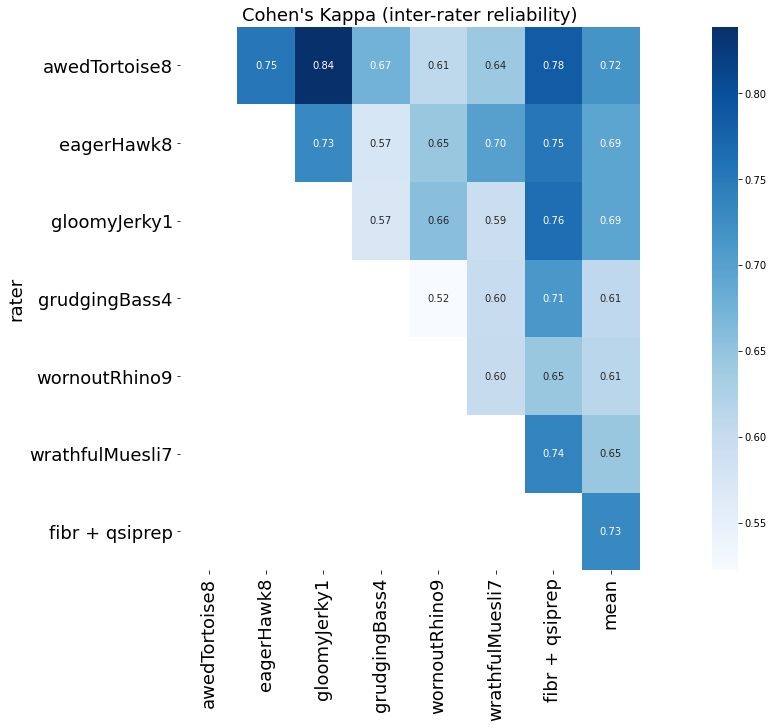

In [17]:
# plot the heatmap for correlation matrix
grid_kws = {"width_ratios": (.9, .05), "wspace": .3}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(10,10))

vmin = df_kappa.to_numpy().min()
vmax = df_kappa.to_numpy().max()

ax = sns.heatmap(
    df_kappa,
#     vmin=vmin, vmax=vmax, center=0.5,
    cmap=sns.color_palette("Blues", as_cmap=True),
    ax=ax,
    cbar_ax=cbar_ax,
#     square=False,
    annot=True, fmt='.2f',
    mask=np.tril(np.ones_like(df_kappa.to_numpy()))
)

_ = ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=18
)

_ = ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=18
)

_ = ax.set_ylabel("rater", fontsize=18)

ax.set_title("Cohen's Kappa (inter-rater reliability)", fontsize=18)

fig.savefig("../expert-ratings/expert-raters-cohens-kappa.png", bbox_inches="tight")